In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import pandas as pd

### Calculate the Total Energy Stored in Resonator

In [3]:
# Define folder and file name separately
folder = r'C:\Users\user\Desktop\CU Boulder Life\博二下\McRae_Lab\Ring Resonators in a Coffin-style Microwave Package\Apr_16_Cross_Section\follow_paper'
efile = r'E_sq_halfview_0P001um'
dfile = r'D_sq_halfview_0P001um'

efile_path = os.path.join(folder, efile)
dfile_path = os.path.join(folder, dfile)


# Load data (skip header rows)
edata = np.loadtxt(os.path.join(folder, efile), skiprows=2)
ddata = np.loadtxt(os.path.join(folder, dfile), skiprows=2)

# Extract X, Y (assuming identical grid)
x = edata[:, 0]
y = edata[:, 1]
e2 = edata[:, 3]
d2 = ddata[:, 3]

# Compute √(|D|² / |E|²), handling zero-division safely
epsilon = np.sqrt(np.divide(d2, e2, out=np.zeros_like(d2), where=e2!=0))

# Get sorted unique x and y
x_unique = np.unique(x)
y_unique = np.unique(y)

# Build a 2D array explicitly
x_index = {val: i for i, val in enumerate(x_unique)}
y_index = {val: i for i, val in enumerate(y_unique)}

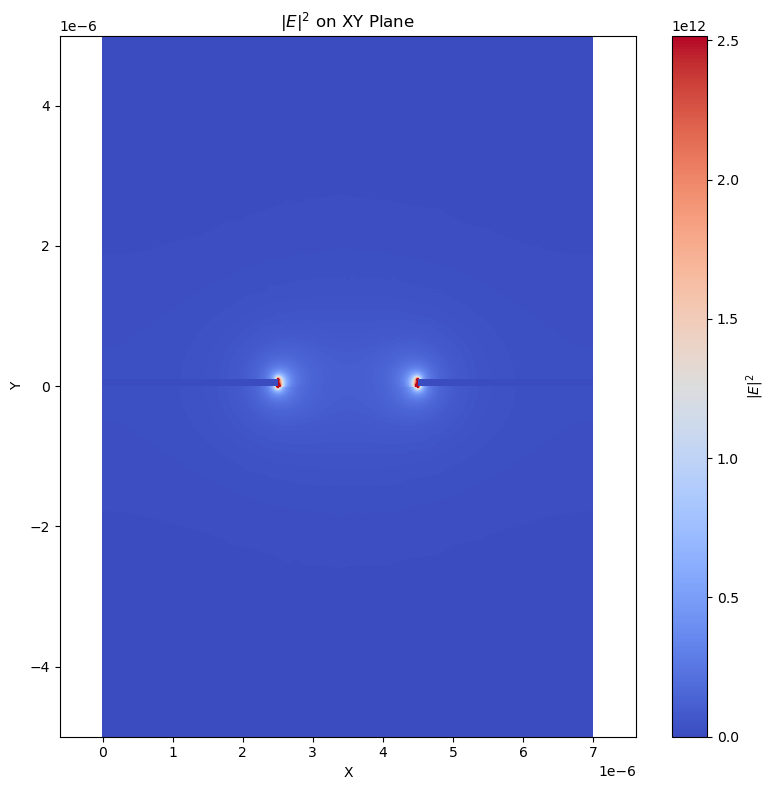

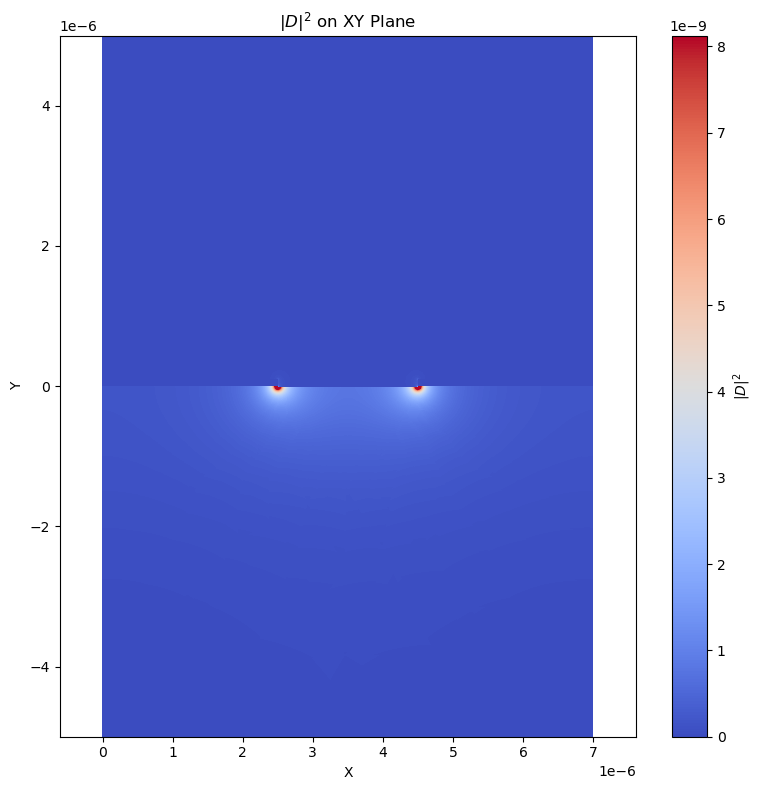

ValueError: 
$\epsilon_r}$ on XY Plane
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x000002D3F7F08540> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
$\epsilon_r}$ on XY Plane
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$\epsilon_r}$ on XY Plane
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 800x800 with 2 Axes>

In [ ]:
####################
#### Plot |E|^2 ####
####################
# Create a mapping from (x, y) for plotting |E|²
E2 = np.full((len(y_unique), len(x_unique)), np.nan)

for xi, yi, ei in zip(x, y, e2):
    i = y_index[yi]
    j = x_index[xi]
    E2[i, j] = ei

# Create meshgrid
X, Y = np.meshgrid(x_unique, y_unique)

# Clip color scale
vmin = 0
vmax = np.nanpercentile(E2, 99.99)

# Plot with 'coolwarm' colormap, where red represents stronger values and blue represents weaker values
plt.figure(figsize=(8, 8))
plt.pcolormesh(X, Y, E2, shading='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'$|E|^2$ on XY Plane')
plt.colorbar(label=r'$|E|^2$')
plt.axis('equal')
plt.tight_layout()
plt.show()

####################
#### Plot |D|^2 ####
####################
# Create a mapping from (x, y) for plotting |D|²
D2 = np.full((len(y_unique), len(x_unique)), np.nan)

for xi, yi, di in zip(x, y, d2):
    i = y_index[yi]
    j = x_index[xi]
    D2[i, j] = di

# Create meshgrid
X, Y = np.meshgrid(x_unique, y_unique)

# Clip color scale
vmin = 0
vmax = np.nanpercentile(D2, 99.99)

# Plot with 'coolwarm' colormap, where red represents stronger values and blue represents weaker values
plt.figure(figsize=(8, 8))
plt.pcolormesh(X, Y, D2, shading='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'$|D|^2$ on XY Plane')
plt.colorbar(label=r'$|D|^2$')
plt.axis('equal')
plt.tight_layout()
plt.show()


######################
#### Plot epsilon ####
######################
# Create a 2D grid to hold the epsilon values (initialized to NaN)
epsilon_0 = 8.85E-12 # in F/m
# Calculate epsilon_r as 1D array
epsilon_r = epsilon/ epsilon_0  # make sure epsilon_values is already calculated

epsilon_r_grid = np.full((len(y_unique), len(x_unique)), np.nan)

# Map (x, y) → epsilon values
for xi, yi, eps_r_i in zip(x, y, epsilon_r):  # <- use the correct 1D array name
    i = y_index[yi]
    j = x_index[xi]
    epsilon_r_grid[i, j] = eps_r_i

# Create meshgrid
X, Y = np.meshgrid(x_unique, y_unique)

# Clip color scale
vmin = 0
vmax = np.nanpercentile(epsilon_r_grid, 99.99)

# Plot
plt.figure(figsize=(8, 8))
plt.pcolormesh(X, Y, epsilon_r_grid, shading='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'$\epsilon_r$ on XY Plane')
plt.colorbar(label=r'$\epsilon_r$')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
####################################
#### Calculate the Total Energy ####
####################################
 

### Calculate the E-field at Interface

In [ ]:
# --- Set folder and file name ---
folder = r'C:\Users\user\Desktop\CU Boulder Life\博二下\McRae_Lab\Ring Resonators in a Coffin-style Microwave Package\Apr_01_Cross_Section\Check_Integral_Convergence'
file_name = r'MA_2001.csv'
file_path = os.path.join(folder, file_name)

# --- Load CSV with header ---
df = pd.read_csv(file_path, header=0)

# --- Determine unit of distance from header ---
distance_label = df.columns[0].lower()
if 'nm' in distance_label:
    unit_scale = 1e-9  # convert nm to meters
    distance_unit = 'nm'
elif 'um' in distance_label or 'μm' in distance_label:
    unit_scale = 1e-6  # convert μm to meters
    distance_unit = 'μm'
else:
    raise ValueError("Unknown distance unit: please include 'nm' or 'um' in the first column header.")

# --- Extract data ---
distance_raw = df.iloc[:, 0].values
distance_m = distance_raw * unit_scale
E_para = df.iloc[:, 1].values
E_perp = df.iloc[:, 2].values

In [ ]:
# --- Plot E_para and E_perp vs distance ---
plt.figure(figsize=(6, 4))
plt.plot(distance_raw, E_para, label='E_para [V/m]')
plt.plot(distance_raw, E_perp, label='E_perp [V/m]')
plt.xlabel(f'Distance [{distance_unit}]')
plt.ylabel('Electric Field [V/m]')
plt.title('Electric Field Components vs Distance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Compute |E|^2 and integrate ---
E_para_sq = np.abs(E_para) ** 2
E_perp_sq = np.abs(E_perp) ** 2

int_E_para_sq = simpson(E_para_sq, x=distance_m)
int_E_perp_sq = simpson(E_perp_sq, x=distance_m)


print(f"∫|E_para|^2 dx = {int_E_para_sq:.4e} V^2·m")
print(f"∫|E_perp|^2 dx = {int_E_perp_sq:.4e} V^2·m")

In [ ]:
# Define common parameter
W = 1  # energy per unit length in Joules/m

if 'MA' in file_name:
    epsilon_MA = 10
    t_MA = 3e-9 # thickness in meters
    result_MA = (1 / epsilon_MA) * int_E_perp_sq * (t_MA / W)
    print(f"[MA] Participation Ratio = {int(result_MA * 1e6)} ppm")

elif 'MS' in file_name:
    epsilon_S = 10
    epsilon_MS = 10
    t_MS = 3e-9 # thickness in meters
    result_MS = (epsilon_S ** 2 / epsilon_MS) * int_E_perp_sq * (t_MS / W)
    print(f"[MS] Participation Ratio = {int(result_MS * 1e6)} ppm")

elif 'SA' in file_name:
    epsilon_SA = 10
    t_SA = 3e-9 # thickness in meters
    term_para = epsilon_SA * int_E_para_sq
    term_perp = (1 / epsilon_SA) * int_E_perp_sq
    result_SA = (term_para + term_perp) * (t_SA / W)
    print(f"[SA] Participation Ratio = {int(result_SA * 1e6)} ppm")

elif 'C' in file_name:
    epsilon_MA = 10
    t_MA = 3e-9 # thickness in meters
    result_C = (1 / epsilon_MA) * int_E_perp_sq * (t_MA / W)
    print(f"[C] Participation Ratio = {int(result_C * 1e6)} ppm")

else:
    print("No interface type detected in filename.")